In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

from pathlib import Path
import pandas as pd

image_dir = Path('/Users/nijat/Downloads/split_data/')


filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r"**/**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

image_df = image_df.sample(frac=1).reset_index(drop=True)

image_df['dataset'] = image_df['Filepath'].apply(lambda x: x.split('/')[-3])

train_df = image_df[image_df['dataset']=='train']
test_df = image_df[image_df['dataset']=='test']

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Ignore errors if no GPU is found
  pass

print(physical_devices)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 3245 validated image filenames belonging to 10 classes.
Found 811 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


In [3]:
pretrained_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Update input shape as required
    #pooling='avg'
)
pretrained_model.trainable = False
pretrained_model.summary()

output = pretrained_model.output

# Apply the new Conv2d block to the output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv1')(output)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv2')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv3')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='block6_gap')(x)
x = tf.keras.layers.Flatten(name='block7_flatten')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create a new model with the combined layers
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x, name='LungNet22')
model.summary()

2024-04-18 16:51:02.407307: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 16:51:02.407338: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-04-18 16:51:02.407345: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-04-18 16:51:02.407388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 16:51:02.407405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300


2024-04-18 16:51:22.049715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 5.2482 - accuracy: 0.1501

2024-04-18 16:51:38.677483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 20s 165ms/step - loss: 5.2482 - accuracy: 0.1501 - val_loss: 2.1650 - val_accuracy: 0.1406
Epoch 2/300
102/102 [==============================] - 16s 154ms/step - loss: 1.8831 - accuracy: 0.2678 - val_loss: 1.5583 - val_accuracy: 0.4217
Epoch 3/300
102/102 [==============================] - 16s 153ms/step - loss: 1.3125 - accuracy: 0.5140 - val_loss: 1.3721 - val_accuracy: 0.4920
Epoch 4/300
102/102 [==============================] - 16s 152ms/step - loss: 0.9837 - accuracy: 0.6450 - val_loss: 0.9733 - val_accuracy: 0.6572
Epoch 5/300
102/102 [==============================] - 16s 152ms/step - loss: 0.7062 - accuracy: 0.7455 - val_loss: 0.9111 - val_accuracy: 0.6695
Epoch 6/300
102/102 [==============================] - 15s 152ms/step - loss: 0.4773 - accuracy: 0.8280 - val_loss: 0.9701 - val_accuracy: 0.7053
Epoch 7/300
102/102 [==============================] - 16s 152ms/step - loss: 0.3841 - accuracy: 0.8632 - val_loss: 0.9478 - val_accurac

In [6]:
model.save('VGG19_LungNet22.keras')

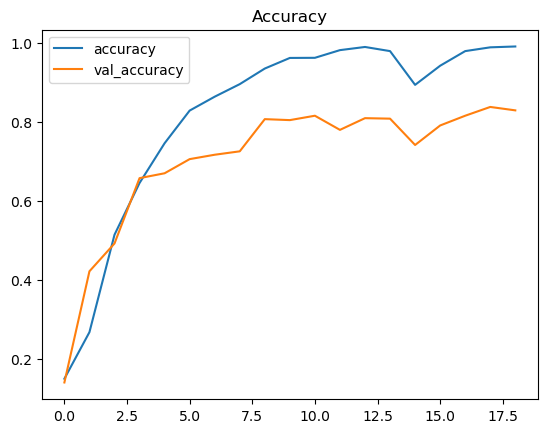

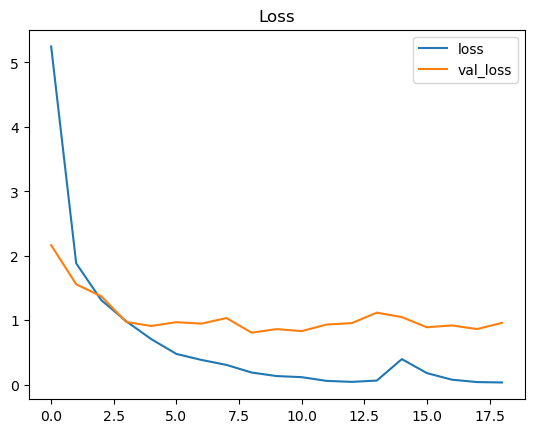

    Test Loss: 0.78180
Test Accuracy: 81.65%


In [7]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()


results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [8]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]
print(f'The first 6 predictions: {pred[:6]}')

 2/32 [>.............................] - ETA: 1s

2024-04-18 16:56:41.604608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 129ms/step
The first 6 predictions: ['covid', 'pneumonia', 'mass', 'tuberculosis', 'pneumothorax', 'effusion']


                    precision    recall  f1-score   support

           control       0.99      0.97      0.98       116
             covid       0.95      0.91      0.93       101
          effusion       0.75      0.76      0.76       100
      lung Opacity       0.90      0.78      0.83       100
              mass       0.72      0.77      0.74       101
            nodule       0.85      0.81      0.83       101
         pneumonia       0.87      0.73      0.79       100
      pneumothorax       0.68      0.76      0.72       100
pulmunary fibrosis       0.70      0.86      0.77        99
      tuberculosis       0.81      0.78      0.79       101

          accuracy                           0.82      1019
         macro avg       0.82      0.81      0.82      1019
      weighted avg       0.82      0.82      0.82      1019



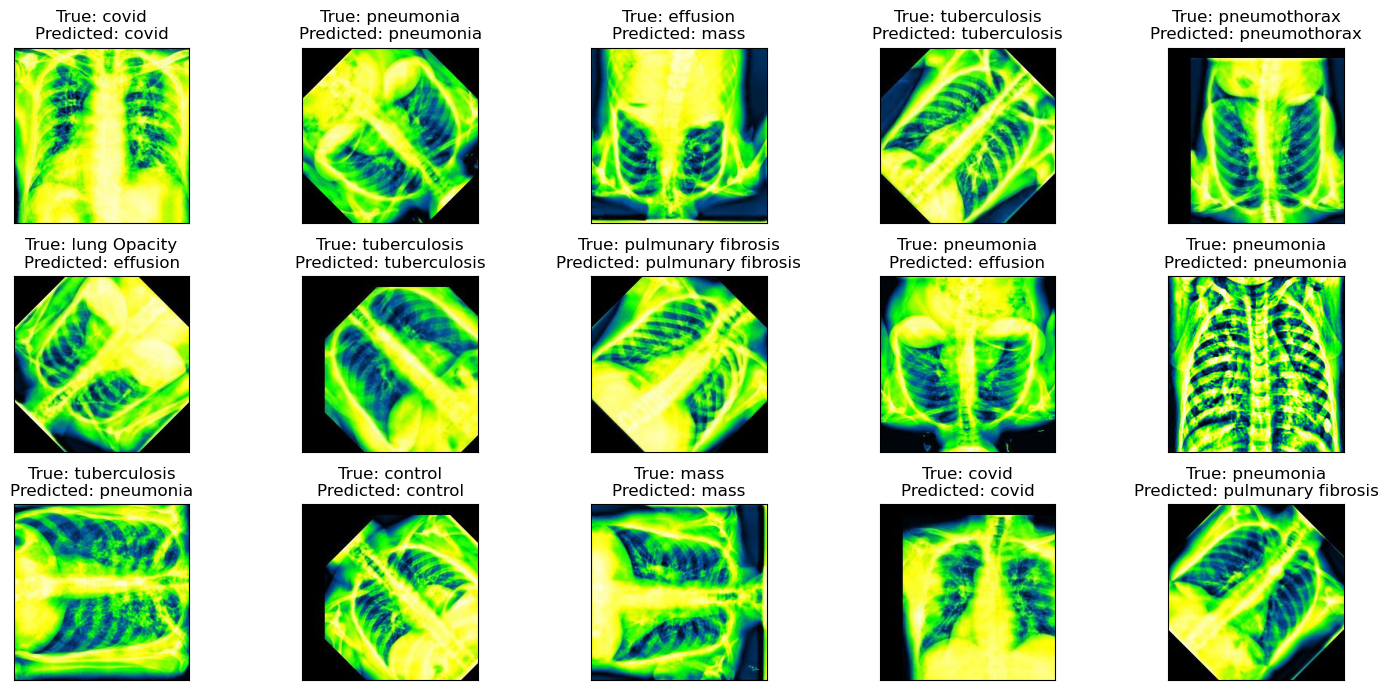

In [9]:
from sklearn.metrics import classification_report

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()